# Génération de gaussienne par modèle de diffusion

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import normal
import matplotlib.pyplot as plt
import numpy as np
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

(1000, 2)


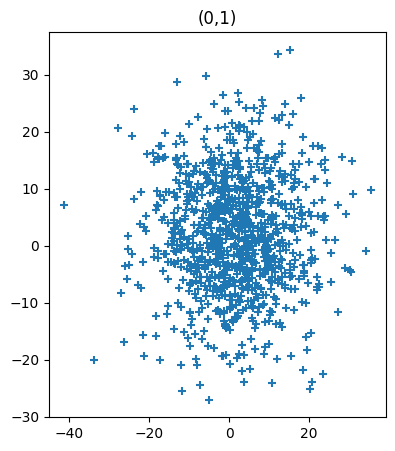

In [2]:
def show_points(X):
    print(X.shape)
    nb_points,dim = X.shape
    plt.figure(figsize=(dim*(dim-1) * 10,5))
    nb_plot=0
    for d1 in range(dim):
        for d2 in range(d1+1,dim):
            xs,ys = [],[]
            nb_plot+=1
            for i in range(nb_points):
                xs.append(X[i][d1])
                ys.append(X[i][d2])
            plt.subplot(1,dim**2,nb_plot)
            plt.title(f"({d1},{d2})")
            plt.scatter(xs,ys, marker='+')
    plt.show()
    return
n_steps = 1000
dim = 2
points = np.array([torch.normal(mean=2*torch.ones((dim,)), std=10*torch.ones((dim,))) for _ in range(1000)])
show_points(points)

In [90]:
class Net(nn.Module):
    def __init__(self,inpSize,outpSize):
        """
        Ce network sert à sampler epsilon_theta (x_t,t)
        """
        super(Net,self).__init__()
        self.inpsize = inpSize
        self.linear1 = torch.nn.Linear(inpSize,256).to(device)
        self.act = torch.nn.SiLU().to(device)
        self.linear2 = torch.nn.Linear(256,3).to(device)
        self.linear3 = torch.nn.Linear(4,outpSize).to(device)

    def forward(self,x,t):
        x = x.to(device)
        x = self.act(self.linear2(self.act(self.linear1(x))))
        z = torch.cat([x, t.unsqueeze(1)], dim=1).to(device)
        out = self.linear3(z).to(device)
        return out

linearNet = Net(dim,dim)

In [91]:
class Diff(nn.Module):
    def __init__(self,network, num_timesteps,beta_start = 1e-4, beta_end = 2e-2, device = "cpu"):
        super(Diff,self).__init__()
        self.num_timesteps = num_timesteps
        self.betas = torch.linspace(beta_start,beta_end,num_timesteps,dtype=torch.float32).to(device)
        #self.betas = self.betas.to(device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas,axis=0)
        self.network = network
        self.device = device
        self.sqrt_alphas_cumprod = self.alphas_cumprod**0.5
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod) ** 0.5
    def add_noise(self, x_start, x_noise, timesteps):
        """
        
        """
        s1 = self.sqrt_alphas_cumprod[timesteps].reshape(-1,1).to(device) # bs
        s2 = self.sqrt_one_minus_alphas_cumprod[timesteps].reshape(-1,1).to(device) # bs
        return x_start * s1+  x_noise * s2
    def reverse(self,x,t):
        return self.network(x,t)
    def step(self, model_output, timestep, sample):
        # model_output = epsilon_theta, timestep = t, sample = x_t
        # but: avoir x_{t-1}
        t = timestep
        coef_eps_t= ((1-self.alphas[t])/self.sqrt_one_minus_alphas_cumprod[t]).reshape(-1,1).to(device)
        coef_first_t = (1/self.alphas[t] ** 0.5).reshape(-1,1).to(device)
        pred_prev_sample = (coef_first_t*(sample-coef_eps_t*model_output)).to(device)
        variance = 0
        if t > 0:
            noise = torch.randn_like(model_output).to(self.device)
            variance = ((self.betas[t] ** 0.5) * noise).to(device)

        pred_prev_sample = pred_prev_sample + variance
        return pred_prev_sample.to(device)

In [92]:
def training_loop(model,dataloader,optim,num_ep,num_timesteps,device=device):
    global_step = 0
    losses = []
    for epoch in range(num_ep):
        if epoch!= 0: print(f"New epoch ({epoch}) last losses: {losses[-1]}" )
        model.train()
        l = 0
        for step, batch in enumerate(dataloader):
            batch = batch.to(device) # les x0 avec lesquels je vais me train.
            noise = torch.randn(batch.shape).to(device) # un epsilon par x0 pour les flouter
            timesteps = torch.randint(num_timesteps,(batch.shape[0],)).long().to(device)
            noisy = model.add_noise(batch, noise, timesteps) # xt
            noise_pred = model.reverse(noisy, timesteps) # on essaye de prédire le epsilon à partir des images floutées.
            loss = F.mse_loss(noise_pred, noise)
            optim.zero_grad()
            loss.backward()
            optim.step()
            l+=loss.detach().item()
            global_step += 1
        losses.append(l/len(dataloader))

In [93]:
from torch.utils.data import Dataset, DataLoader

In [94]:
class MultivariateNormalDataset(Dataset):
    def __init__(self, mean,std, num_samples):
        self.data = np.array([torch.normal(mean=mean, std=std) for _ in range(num_samples)])
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]

In [95]:
num_samples = 10000  # Number of samples
batch_size = 32     # Batch size
mean = 4*torch.ones((dim,))
std = 3*torch.ones((dim,))
dataset = MultivariateNormalDataset(mean,std, num_samples)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [96]:

lr = 1e-3
num_epochs = 100
num_timesteps = 200
network = Net(dim,dim)
network = network.to(device)
model = Diff(network,num_timesteps,device = device)
optimizer = torch.optim.Adam(network.parameters(), lr=lr)
training_loop(model,dataloader,optimizer,num_epochs,num_timesteps)

New epoch (1) last losses: 290.8569907410838
New epoch (2) last losses: 23.426094387286007
New epoch (3) last losses: 8.10965469013007
New epoch (4) last losses: 3.7408635848627303
New epoch (5) last losses: 2.0414022755699035
New epoch (6) last losses: 1.4090724290369419
New epoch (7) last losses: 1.168087669073964
New epoch (8) last losses: 1.0683682863704693
New epoch (9) last losses: 1.0260057017064323
New epoch (10) last losses: 0.9816442581411368
New epoch (11) last losses: 0.9903784091480243
New epoch (12) last losses: 0.9910186342537974
New epoch (13) last losses: 0.9767926373420813
New epoch (14) last losses: 0.9602064469370979
New epoch (15) last losses: 0.9819036099476556
New epoch (16) last losses: 0.9740798501922681
New epoch (17) last losses: 0.969984843898505
New epoch (18) last losses: 0.9564936416217694
New epoch (19) last losses: 0.9724559387840783
New epoch (20) last losses: 0.9787012548111498
New epoch (21) last losses: 0.9605540835057584
New epoch (22) last losses:

In [97]:
def genere_un_point(model):
    sample = torch.randn(dim).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        timesteps = list(range(model.num_timesteps))[::-1]
        for i,t in enumerate(timesteps):
            time_tensor = (torch.ones(1,) * t).long().to(device)
            residual = model.reverse(sample,time_tensor)
            sample = model.step(residual,time_tensor,sample) # p(xt-1 | xt), prend en entrée le epislon_theta, et le temps où on est, et la version floutée.
    return sample

In [98]:
X = torch.tensor([])
X = X.to('cpu')
for i in range(200):
    if i%30 ==0 and i!=0: print(f"generated {i} images.")
    x = genere_un_point(model)
    x = x.to('cpu')
    X = torch.concatenate((X, x))

generated 30 images.
generated 60 images.
generated 90 images.
generated 120 images.
generated 150 images.
generated 180 images.


torch.Size([200, 2])


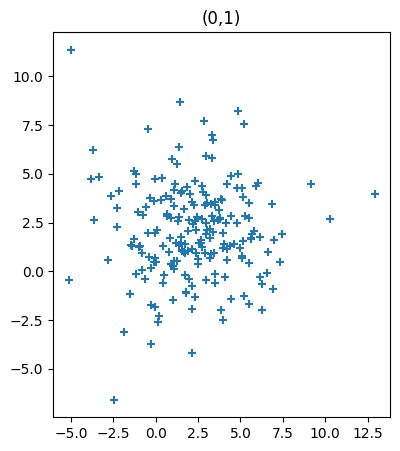

In [99]:
show_points(X)

In [101]:
torch.mean(X, axis=0)

tensor([2.2507, 2.0525])

In [102]:
torch.std(X, axis=0)

tensor([2.7382, 2.4497])

In [18]:
class CarreDataset(Dataset):
    def __init__(self, mean, std, num_samples):
        #self.data = np.array([torch.normal(mean=mean, std=std) for _ in range(num_samples)])
        self.data = torch.rand(num_samples, 2) * 2 - 1
        self.data += mean
        self.data *= std
        self.num_saples = num_samples
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]

torch.Size([10000, 2])


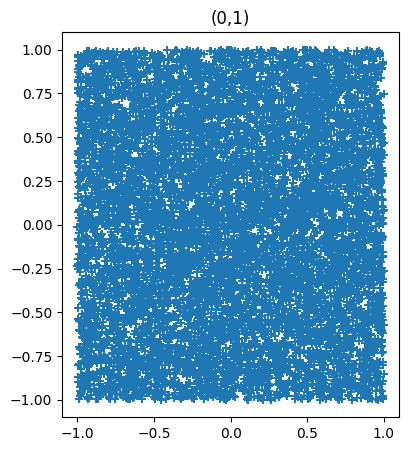

In [19]:
num_samples = 10000  # Number of samples
batch_size = 32     # Batch size
mean = 0
std = 1
dataset2 = CarreDataset(mean, std, num_samples)
show_points(dataset2.data)
dataloader2 = DataLoader(dataset2, batch_size=batch_size, shuffle=True)

In [20]:
lr = 1e-3
num_epochs = 100
num_timesteps = 200
network2 = Net(dim+1,dim)
network2 = network.to(device)
model2 = Diff(network2,num_timesteps,device = device)
optimizer = torch.optim.Adam(network2.parameters(), lr=lr)
training_loop(model2,dataloader2,optimizer,num_epochs,num_timesteps)

New epoch (1) last losses: 8.249474368632411
New epoch (2) last losses: 2.255012931058201
New epoch (3) last losses: 1.2030669830668086
New epoch (4) last losses: 0.9899292054077307
New epoch (5) last losses: 0.726494736660022
New epoch (6) last losses: 0.6389559269332277
New epoch (7) last losses: 0.5690963545355934
New epoch (8) last losses: 0.5586230875775456
New epoch (9) last losses: 0.5505437422484255
New epoch (10) last losses: 0.5538588036744359
New epoch (11) last losses: 0.5267018773875678
New epoch (12) last losses: 0.51573936336528
New epoch (13) last losses: 0.5728343936581962
New epoch (14) last losses: 0.5445523280114792
New epoch (15) last losses: 0.5208371985263337
New epoch (16) last losses: 0.5281383729399964
New epoch (17) last losses: 0.5227554150568411
New epoch (18) last losses: 0.511281278996041
New epoch (19) last losses: 0.5440695622858529
New epoch (20) last losses: 0.5349816415732661
New epoch (21) last losses: 0.5188772774542483
New epoch (22) last losses: 

(500, 2)


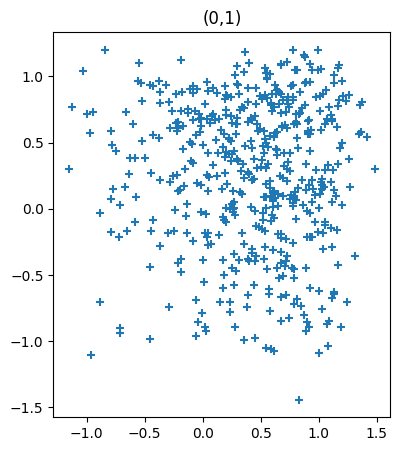

In [21]:
X = []
for i in range(500):
    X.append(genere_un_point(model2)[0])
    #if len(X) % 500 == 0 and len(X)>0:
Y = [x.cpu() for x in X]
show_points(np.array(Y))

In [22]:
class SpiraleDataset(Dataset):
    def __init__(self, theta_max, a, b, num_samples):
        theta = torch.rand(num_samples) * theta_max
        radius = a + b * theta
        self.data = torch.stack((radius * torch.cos(theta), radius * torch.sin(theta)), dim=1)
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]

torch.Size([10000, 2])


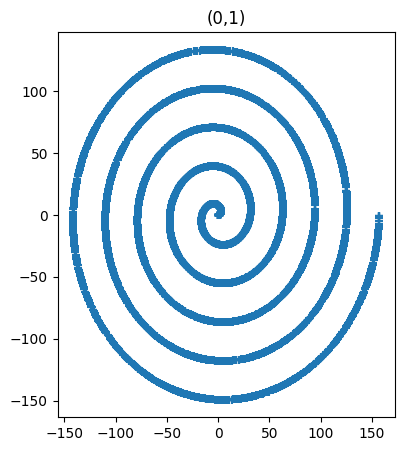

In [29]:
num_samples = 10000  # Number of samples
batch_size = 32     # Batch size
mean = 0
std = 1
dataset3 = SpiraleDataset(10 * torch.pi, 0, 5, num_samples)
show_points(dataset3.data)
dataloader3 = DataLoader(dataset3, batch_size=batch_size, shuffle=True)

In [32]:
lr = 1e-3
num_epochs = 100
num_timesteps = 500
network3 = Net(dim+1,dim)
network3 = network3.to(device)
model3 = Diff(network3,num_timesteps,device = device)
optimizer = torch.optim.RMSprop(model3.parameters(), lr=lr)
training_loop(model3,dataloader3,optimizer,num_epochs,num_timesteps)

New epoch (1) last losses: 53.44994608738933
New epoch (2) last losses: 24.4633190660431
New epoch (3) last losses: 29.369759716926673
New epoch (4) last losses: 25.384695246006352
New epoch (5) last losses: 24.82721868852457
New epoch (6) last losses: 23.43709148176181
New epoch (7) last losses: 22.81621331662035
New epoch (8) last losses: 22.337378693845707
New epoch (9) last losses: 19.875835630269098
New epoch (10) last losses: 16.400504040070615
New epoch (11) last losses: 18.328218235946693
New epoch (12) last losses: 15.253028542660296
New epoch (13) last losses: 17.004066511274527
New epoch (14) last losses: 14.541470157262236
New epoch (15) last losses: 14.16134648353528
New epoch (16) last losses: 11.67818690984013
New epoch (17) last losses: 12.6628207722411
New epoch (18) last losses: 9.89513552874422
New epoch (19) last losses: 10.961271367133996
New epoch (20) last losses: 9.976923594459558
New epoch (21) last losses: 9.206950604725188
New epoch (22) last losses: 8.893294

(125, 2)


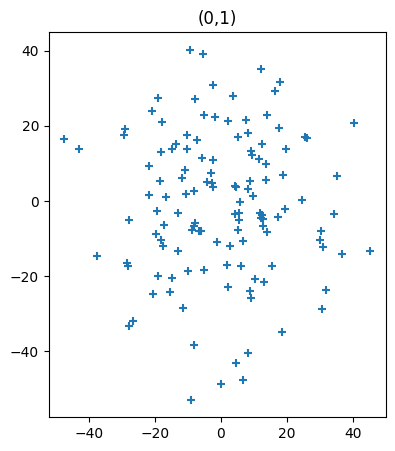

(250, 2)


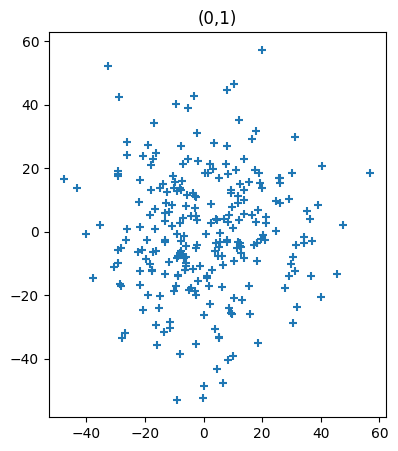

(375, 2)


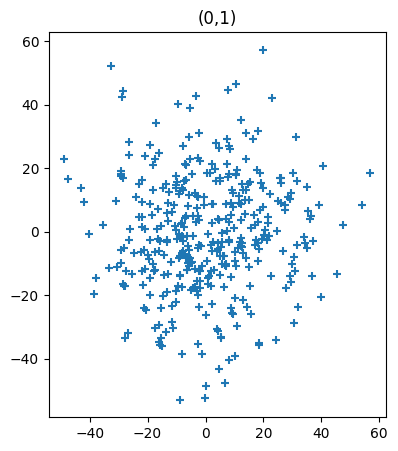

(500, 2)


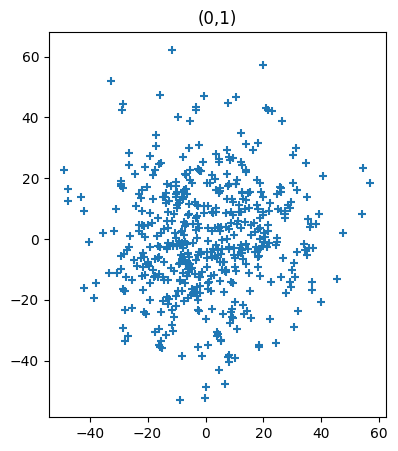

(625, 2)


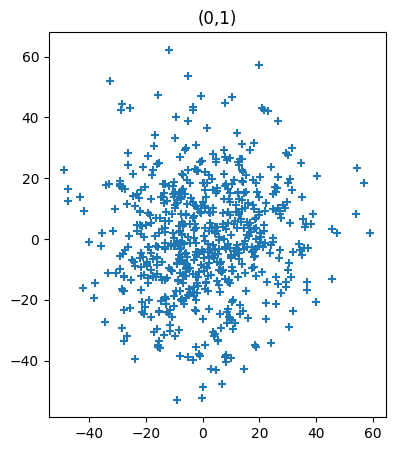

In [ ]:
X = []
for i in range(1000):
    X.append(genere_un_point(model3)[0])
    if len(X) % 125 == 0 and len(X)>0:
        Y = [x.cpu() for x in X]
        show_points(np.array(Y))